In [1]:
cd '../'

/scratch/ssd001/home/ama/workspace/ama-at-vector/freq-robust


In [2]:
%load_ext autoreload
%autoreload 2

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import trange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import grad

from src.attacks import pgd_rand
from src.utils_general import seed_everything
from src.context import ctx_noparamgrad_and_eval
from src.utils_freq import rgb2gray, dct, dct2, idct, idct2, batch_dct2, getDCTmatrix

from models import LR_model
from src.linear_analysis import train_LR
from src.linear_analysis import plot_loss_LR, plot_w_tilde_LR, plot_dw_tilde_LR, plot_loss_adv_LR, plot_risk_LR
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from collections import defaultdict
import ipdb
import copy

# hyper params initalization
_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
args = {"case": 1,
        "itr": 2001, # 8001 works with 0.2
        "bsize": 128,
        "mu": 0,
        "std": 0.5,
        "lambbda": 0.1, # 0.2 works, trying out 0.1 now
        "d": 10,
        "lr": 1e-1,
        "eps": 0.1}

numb_runs = 1
case_list = [1,2,3]
# case_list = [3]
loss_log = torch.zeros(args["itr"], numb_runs, len(case_list))
w_tilde_log = torch.zeros(args["d"], args["itr"], numb_runs, len(case_list))
loss_adv_log = torch.zeros(args["itr"], 3, numb_runs, len(case_list))

with trange(numb_runs*len(case_list)) as t:
    for i in range(numb_runs):
        model = LR_model(args["d"]).to(_device)

        for j in case_list:

            args["case"] = j
            model_copy = copy.deepcopy(model)
            model_copy.to(_device)
            opt = optim.SGD(model_copy.parameters(), lr = args["lr"])
            log = train_LR(args, model_copy, opt, _device)
            loss_log[:,i, args["case"]-1] = log["loss"]
            w_tilde_log[:,:,i, args["case"]-1] = log["w_tilde"]
            loss_adv_log[:,:,i, args["case"]-1] = log["loss_adv"].t()
            
            t.update()

plot_loss_LR(loss_log, threshold = 1e-3, plot_itr = 500)
plot_risk_LR(args, w_tilde_log, loss_log, threshold = 1e-3, plot_itr = 500)
plot_w_tilde_LR(w_tilde_log, threshold = 1e-3)
plot_loss_adv_LR(loss_adv_log, threshold = 1e-3, plot_itr = 500)

100%|██████████| 3/3 [01:53<00:00, 37.37s/it]


NameError: name 'args' is not defined

Above loss threshold! (w_tilde plot)  0 1
Above loss threshold! (w_tilde plot)  0 2
Above loss threshold! (w_tilde plot)  0 3
Above loss threshold! (w_tilde plot)  0 4
Above loss threshold! (w_tilde plot)  0 5
Above loss threshold! (w_tilde plot)  0 6
Above loss threshold! (w_tilde plot)  0 7
Above loss threshold! (w_tilde plot)  0 8
Above loss threshold! (w_tilde plot)  0 9
Above loss threshold


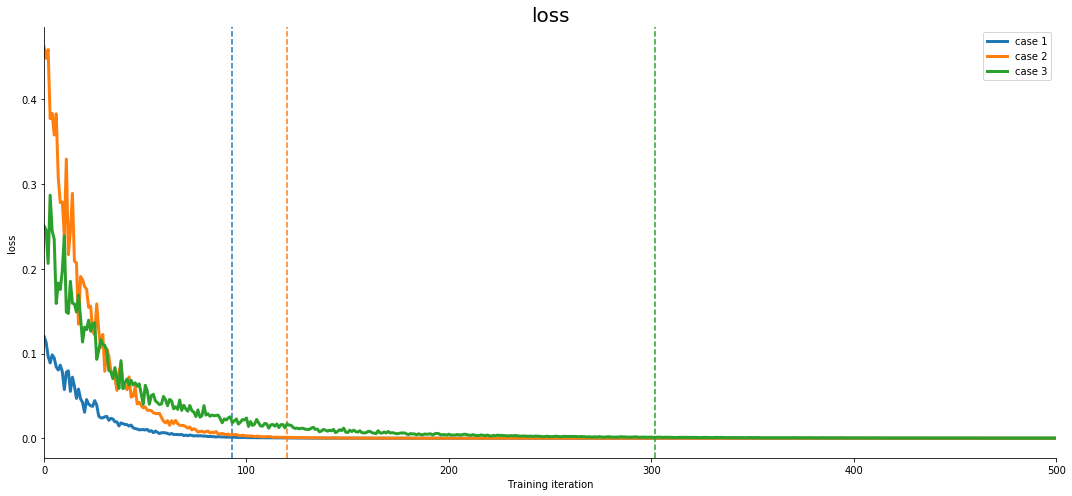

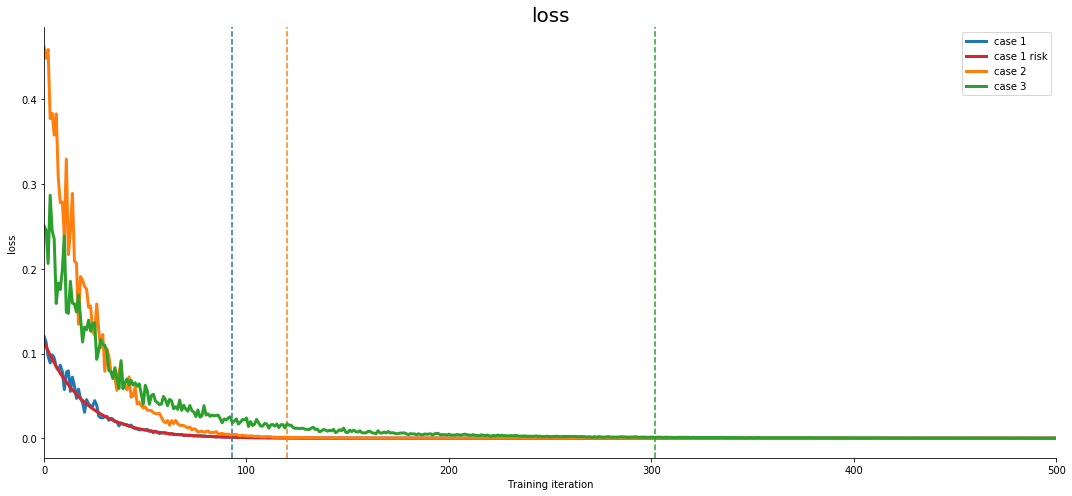

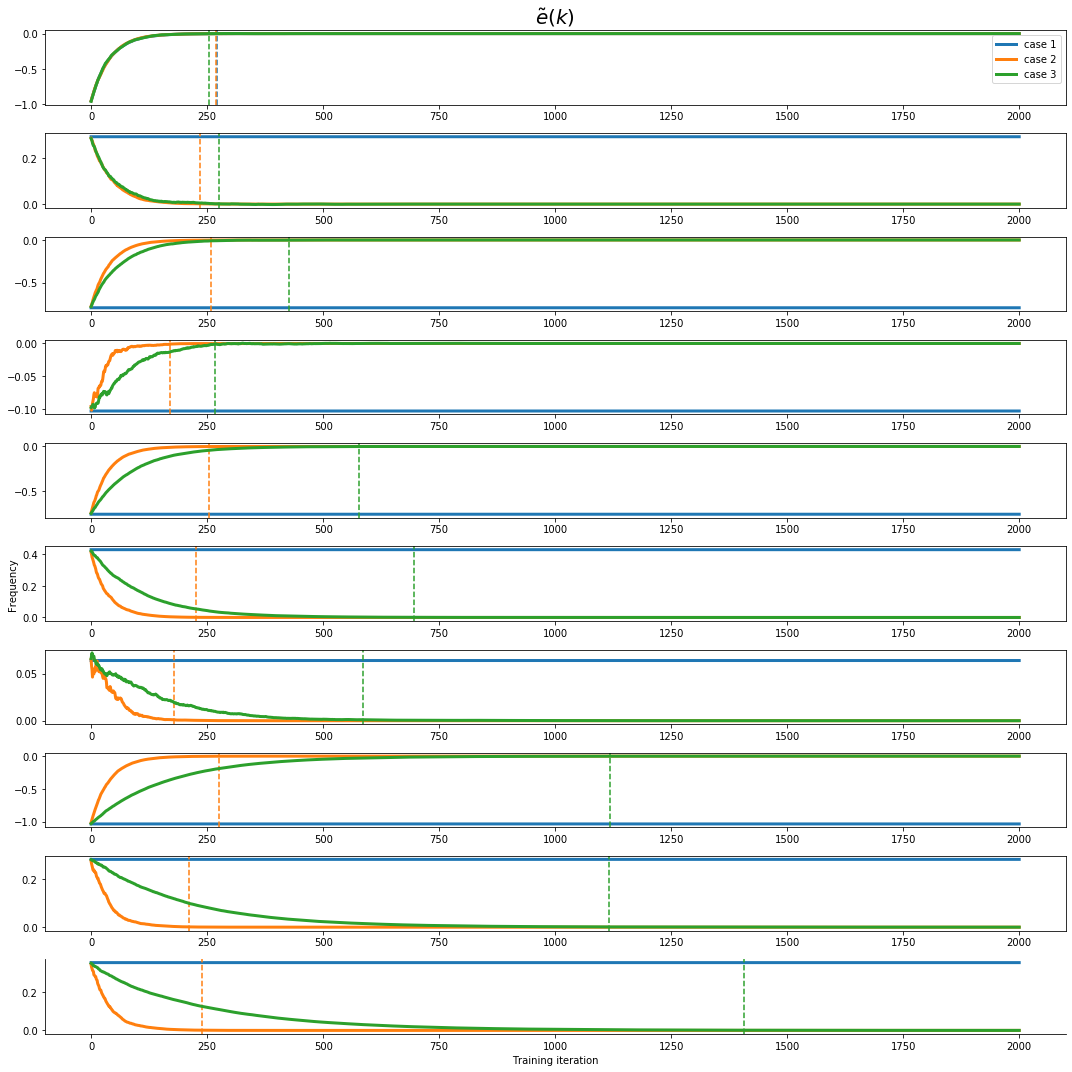

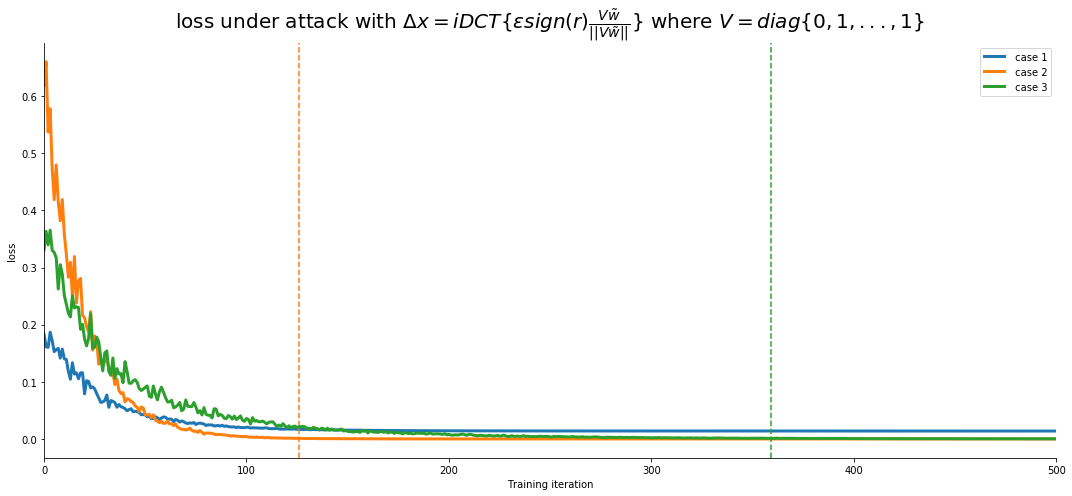

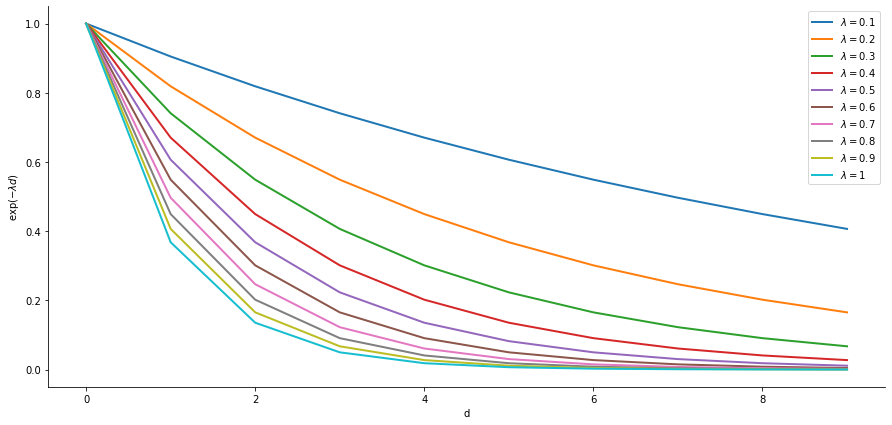

In [10]:
# batchsize = 2
lambbda = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# lambbda = [0.1]
d = 10
# alpha = torch.normal(mean = 1, std = 0.3, size = (d, batchsize))
# decay = torch.exp(-lambbda*(torch.range(1, d)-1).view(d,1).repeat(1, batchsize))
# decay = torch.exp(-lambbda*(torch.range(1, d)-1))
# x_tilde = decay
plt.figure(figsize = [15,7])
for i,j in enumerate(lambbda):
    plt.plot(torch.exp(-j*(torch.range(1, d)-1)), color = "C"+str(i),label = "$\lambda =$"+str(j), linewidth=2.0, marker = "")
plt.legend(prop={"size": 10})
plt.xlabel("d")
plt.ylabel("$\exp(-\lambda d)$")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)